<function matplotlib.pyplot.show(close=None, block=None)>

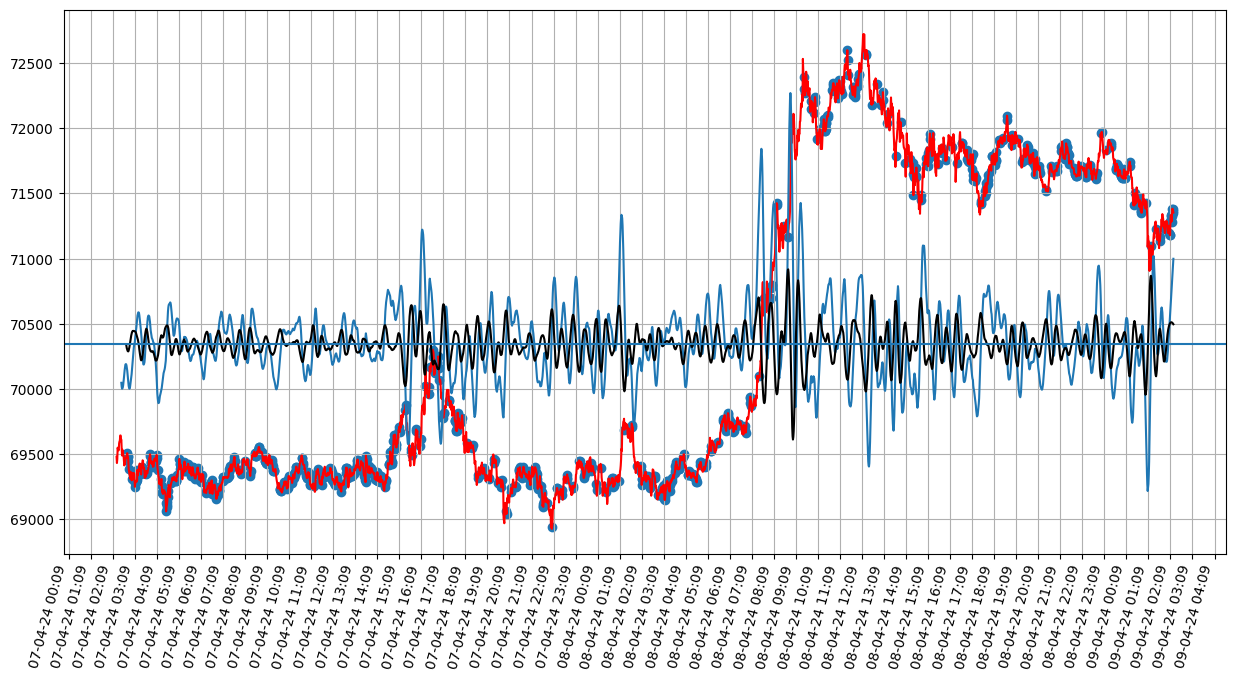

In [2]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

## Conexión con Binance para descargar la lista de pares que binance maneja
from binance import Client
client = Client()


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','2 day ago UTC'))
recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
#recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,25,3)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,25,3)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,25,3)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,25,3)




##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item()
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item()


min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[initial_date_index:final_date_index].SD_Interpolacion.diff()
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.1) & (min_max_sd['Derivada'] <= 0.1)]
indices_min_max = lista_min_max.index.tolist()


######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
drlist = []
lista_min_max = lista_min_max.reset_index()
lista_min_max.columns = ['indice','Derivada']
mp = recent_data.Open[initial_date_index:final_date_index].mean()


for i in range(1,len(lista_min_max)-1):
    if (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[i]*100 < (mp - np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(i)
#        minlist.append(lista_min_max[i])
    elif (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[i]*100 > (mp + np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(i)
#        maxlist.append(lista_min_max[i])


######################################################################
# Gráficas resultantes de los análisis anteriores.
######################################################################
# plt.axvline(halving_dates['Halving_Dates'][2])
# plt.axvline(halving_dates['Halving_Dates'][3])
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Open[initial_date_index:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(30)+mp)
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[indices_min_max],recent_data.Open.iloc[indices_min_max])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
# plt.axhline(np.std(recent_data.SD_Interpolacion)*10 + mp)
# plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*10)
# plt.axvline(6500)
plt.show

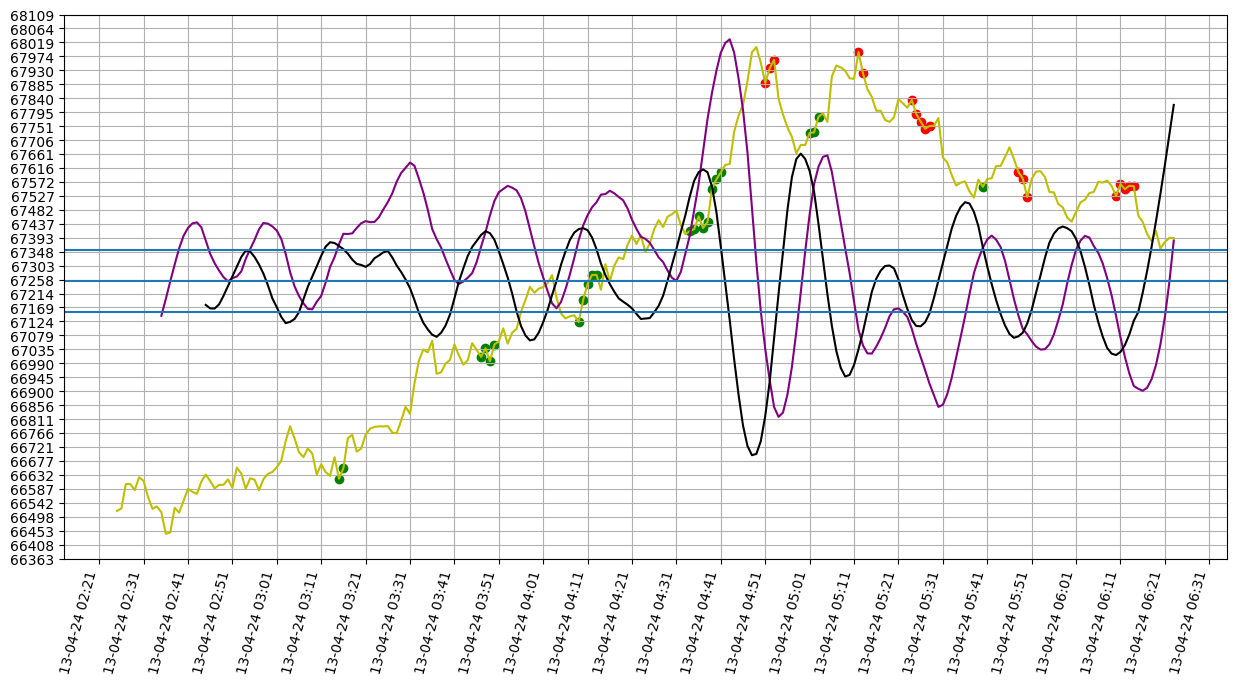

In [1]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
from time import sleep
from IPython.display import clear_output

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 20
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 0
std_mult = 135000
pdi_mult = 1000
sdi_mult = 250000
z_aprox = 0.1
pmax_idx = 0
pmin_idx = 0


while True:
    clear_output(wait=True)
    ##################################################################################################################################
    # Descarga y limpieza de datos de X días atrás a hoy.
    ##################################################################################################################################
    recent_data = pd.DataFrame(client.get_historical_klines('BTCTUSD','1m','4 hours ago UTC'))
    recent_data = recent_data.iloc[:,:6]
    recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
    recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
    recent_data = recent_data.set_index('Tiempo')
    recent_data = recent_data.astype(float)
    recent_data = recent_data.reset_index()

    ##################################################
    # Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
    ##################################################
    recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,3)
    recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,3)
    recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,3)
    recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

    ######################################################################
    # Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
    ######################################################################
    initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
    final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

    lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
    indices_min_max = lista_min_max.index.tolist()

    max_points_idx = []
    min_points_idx = []
    pmin = 0
    pmax = 0

    for PMSD in indices_min_max:
        if (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() > 0):
            if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmax_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmax_idx = PMSD+i
            max_points_idx.append(pmax_idx)
        elif (recent_data.SD_Interpolacion[PMSD:PMSD+1].item()) < 0 & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() < 0):
            if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmin_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmin_idx = PMSD+i
            min_points_idx.append(pmin_idx)
    max_points_idx = list(set(max_points_idx))
    min_points_idx = list(set(min_points_idx))
    max_points_idx.sort()
    min_points_idx.sort()

    # close_points_max = []
    # close_points_min = []
    # for lista in [max_points_idx,min_points_idx]:
    #     for i in range(len(lista)-1):
    #         if lista[i+1]-lista[i] <= 2:
    #             if lista == max_points_idx:
    #                 close_points_max.append(i+1)
    #             else:
    #                 close_points_min.append(i+1)
    #     if lista == max_points_idx:
    #         for idx in sorted(close_points_max,reverse=True):
    #             del lista[idx]
    #     else:
    #         for idx in sorted(close_points_min,reverse=True):
    #             del lista[idx]

    ######################################################################
    # Ahora ya podemos visualizar los resultados con el siguiente código.
    ######################################################################
    mp = recent_data.Open[initial_date_index:final_date_index].mean()
    plt.figure(figsize=(15,8))
    plt.plot(recent_data.Tiempo[initial_date_index - rango:final_date_index + rango],recent_data.Open[initial_date_index - rango:final_date_index + rango].multiply(1),color='y')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(1000)+mp,'purple')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(250000)+mp,color='k')
    # plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.TD_Interpolacion[initial_date_index:final_date_index].multiply(300)+mp,color='y')
    plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Open.iloc[max_points_idx],color='g')
    plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Open.iloc[min_points_idx],color='r')
    plt.grid(visible=True)

    # Set minor tick locations.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.gca().yaxis.set_major_locator(ticker.LinearLocator(40))
    plt.gcf().autofmt_xdate()

    # Set grid to use minor tick locations. 
    plt.grid(which = 'minor')
    plt.xticks(rotation=75)
    plt.axhline(mp)
    plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
    plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
    # plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
    plt.show()
    # sleep(15)

In [26]:
recent_data[-600:]

,Tiempo,Par,Open,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
10709,2024-04-10 03:56:54.883,BTCUSDT,69125.21,69126.261185,0.301305,-0.004864,0.023312,0.037095,-0.013209,-0.000091
10710,2024-04-10 03:56:56.434,BTCUSDT,69125.22,69126.354916,0.060433,0.012204,0.011004,0.035272,-0.001175,0.002090
10711,2024-04-10 03:56:57.203,BTCUSDT,69122.49,69126.313490,-0.053870,0.050086,0.049262,0.026154,-0.011856,0.004530
10712,2024-04-10 03:56:58.345,BTCUSDT,69122.48,69126.402006,0.077510,0.125940,0.066422,0.033698,0.006606,0.005994
10713,2024-04-10 03:56:59.251,BTCUSDT,69130.00,69126.428754,0.029523,0.109717,-0.017906,0.051766,0.019943,0.007897
...,...,...,...,...,...,...,...,...,...,...
11304,2024-04-10 04:07:06.268,BTCUSDT,69005.56,69010.674118,-1.062083,-1.774352,0.110971,0.184850,0.019171,0.032420
11305,2024-04-10 04:07:07.251,BTCUSDT,69006.96,69009.273063,-1.425284,-1.580668,0.197033,0.213371,0.029015,0.031934
11306,2024-04-10 04:07:07.812,BTCUSDT,69006.97,69008.092451,-2.104479,-1.360002,0.393345,0.241354,0.049880,0.031130
11307,2024-04-10 04:07:09.241,BTCUSDT,69006.97,69007.155340,-0.655781,-1.112041,0.173520,0.268590,0.019060,0.030001


In [13]:
# pmax_df = recent_data.iloc[max_points_idx].iloc[:,:2]
# pmax_df['Accion'] = 'C'
# pmin_df = recent_data.iloc[min_points_idx].iloc[:,:2]
# pmin_df['Accion'] = 'V'
# vc_df = pd.concat([pmax_df,pmin_df],axis=1)
# vc_df = vc_df.reset_index()
# vc_df = vc_df.set_index('index')
# vc_df = pd.concat([pmax_df,pmin_df],axis=0)
# vc_df = vc_df.sort_index()
# del_idx = []
# vc_df = vc_df.reset_index()
# for i in vc_df.index:
#     try:
#         if vc_df.Accion[i+1] == vc_df.Accion[i]:
#             del_idx.append(i+1)
#     except:
#         pass
# vc_df.drop(del_idx,inplace=True)
# vc_df = vc_df.reset_index(drop=True)
# vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
# for i in range(len(vc_df)-1):
#     vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 1
# profits = 0
# for i in range(len(vc_df)-1):
#     if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
#         profits += vc_df.Diferencia_Precio_USDT[i+1]
#     elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
#         profits -= vc_df.Diferencia_Precio_USDT[i+1]
#     elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
#         profits -= vc_df.Diferencia_Precio_USDT[i+1]
#     elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
#         profits += (-1)*(vc_df.Diferencia_Precio_USDT[i+1])
# profits

pmax_df = recent_data.iloc[max_points_idx].iloc[:,:3]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].iloc[:,:3]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=1)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.sort_index()
del_idx = []
vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 0.0001
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits += (-1)*(vc_df.Diferencia_Precio_USDT[i+1])
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_19404\3424730478.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 0.0001


1.3691770000000065

In [21]:
vc_df

,index,Tiempo,Par,Accion,Diferencia_Precio_USDT
0,495,2024-04-10 01:05:09.484,BTCUSDT,V,NaN
1,701,2024-04-10 01:08:36.446,BTCUSDT,C,NaN
2,1222,2024-04-10 01:17:24.840,BTCUSDT,V,NaN
3,1293,2024-04-10 01:18:36.164,BTCUSDT,C,NaN
4,1314,2024-04-10 01:18:57.150,BTCUSDT,V,NaN
5,1331,2024-04-10 01:19:14.326,BTCUSDT,C,NaN
6,1693,2024-04-10 01:25:19.617,BTCUSDT,V,NaN
7,1781,2024-04-10 01:26:48.072,BTCUSDT,C,NaN
8,1814,2024-04-10 01:27:21.360,BTCUSDT,V,NaN
9,1834,2024-04-10 01:27:40.853,BTCUSDT,C,NaN


In [36]:
recent_data

,Tiempo,Open,High,Low,Close,Volume,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
0,2024-04-06 22:16:00,68462.00,68477.16,68461.99,68477.15,4.32397,68425.669323,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-06 22:17:00,68477.15,68477.16,68450.43,68450.43,5.03848,68432.422391,6.753068,NaN,NaN,NaN,NaN,NaN
2,2024-04-06 22:18:00,68450.43,68450.44,68422.00,68422.00,4.50410,68441.496770,9.074379,NaN,NaN,NaN,NaN,NaN
3,2024-04-06 22:19:00,68422.00,68422.01,68418.97,68418.98,2.28443,68452.608764,11.111993,NaN,NaN,NaN,NaN,NaN
4,2024-04-06 22:20:00,68418.98,68439.87,68412.13,68439.87,9.12093,68465.474675,12.865911,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2024-04-08 22:11:00,71694.00,71700.00,71672.00,71672.01,10.92264,71693.741705,-3.484282,-3.646842,-1.351524,-1.446779,-0.064220,-0.071284
2876,2024-04-08 22:12:00,71672.00,71688.15,71672.00,71676.99,8.58952,71688.866723,-4.874982,-5.050950,-1.404108,-1.479156,-0.032377,-0.037702
2877,2024-04-08 22:13:00,71676.99,71696.00,71660.00,71695.99,11.84659,71682.505105,-6.361617,-6.495385,-1.444436,-1.476132,0.003024,0.001035
2878,2024-04-08 22:14:00,71695.99,71696.00,71654.29,71664.22,6.43136,71674.560918,-7.944187,-7.967893,-1.472508,-1.434146,0.041986,0.045144


In [7]:
import pandas as pd
df_test = pd.read_csv('../../csvs/streaming/BTCUSDT.csv')
df_test

,2024-04-10 00:56:43.373,BTCUSDT,69085.76
0,2024-04-10 00:56:44.446,BTCUSDT,69085.76
1,2024-04-10 00:56:45.209,BTCUSDT,69085.76
2,2024-04-10 00:56:45.763,BTCUSDT,69085.77
3,2024-04-10 00:56:48.121,BTCUSDT,69085.77
4,2024-04-10 00:56:48.910,BTCUSDT,69085.77
...,...,...,...
965,2024-04-10 01:13:02.538,BTCUSDT,68869.74
966,2024-04-10 01:13:02.970,BTCUSDT,68869.75
967,2024-04-10 01:13:04.243,BTCUSDT,68869.75
968,2024-04-10 01:13:05.492,BTCUSDT,68868.01


In [ ]:
lim_std = abs(np.std(recent_data.SD_Interpolacion))
sdi_mid = recent_data.SD_Interpolacion[PMSD]
sdi_fron = recent_data.SD_Interpolacion[PMSD+i]
sdi_back = recent_data.SD_Interpolacion[PMSD-i]
pdi_fron = recent_data.PD_Interpolacion[PMSD+i]
pdi_back = recent_data.PD_Interpolacion[PMSD-i]